In [292]:
import imageio
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tnrange
import numpy as np
import math

In [293]:
K = 1.6e6
E = 8e4
alpha = 1.0
Q = 7e5
T_0 = 293 # начальная температура
rho = 830
C = 1990
lamb = 0.13
D = 8e-12
R = 8.31

In [294]:
def update_constants():
    global T_m, kappa, U, beta, gamma, delta_r, delta_h, delta_d, Le
    T_m = T_0 + Q / C # конечная температура
    kappa = lamb / (rho * C)
    U = (2 * K * lamb / (Q * rho * Q / C) * T_0 / T_m * ((R * T_m * T_m / E) ** 2) * np.exp(-E / (R * T_m))) ** 0.5
    beta = R * T_m / E
    gamma = R * T_m * T_m / (E * Q / C)
    delta_h = kappa / U
    delta_r = beta * delta_h
    delta_d = D / U
    Le = delta_d / delta_h

update_constants()

print('Le    = ', Le)
print('beta  = ', beta)
print('gamma = ', gamma)

Le    =  0.00010164307692307692
beta  =  0.06697431972361809
gamma =  0.1227610577254038


Вычислим $D$, при котором число Льюиса $Le$ будет равно 1.\
$Le=\frac{\delta_d}{\delta_h}=1$\
$\delta_d=\delta_h$\
$\frac{D}{U}=\frac{\varkappa}{U}$\
$D=\varkappa$

In [295]:
D = kappa

update_constants()

print('D     = ', D)
print('beta  = ', beta)
print('gamma = ', gamma)

D     =  7.870678694678211e-08
beta  =  0.06697431972361809
gamma =  0.1227610577254038


In [296]:
def set_border_and_step_size():
    global z_steps, t_steps, dz, dt
    a = 0
    b = 3e-2
    dz = 1e-4
    z_steps = int((b-a) / dz)

    theta = 500
    dt = 1e-2
    t_steps = int(theta / dt)

set_border_and_step_size()

In [297]:
def update_start_vectors():
    global t_0, x_0
    t_0 = np.zeros(z_steps, dtype=np.float64)
    x_0 = np.zeros(z_steps, dtype=np.float64)

    for i in range(1):
        t_0[i] = T_m
        x_0[i] = 0

    for i in range(1, z_steps):
        t_0[i] = T_0
        x_0[i] = 1
        
update_start_vectors()

In [298]:
def w(x, t):
    return -K * (x ** alpha) * np.exp(-E / (R * t))

In [299]:
# f = open("file.txt", "w+")
def explicit_downstream():
    Ts = [t_0]
    Xs = [x_0]
    Ws = []
    
    cur_w = [0] * len(x_0)
    for i in range(len(x_0)):
        cur_w[i] = w(x_0[i], t_0[i])
    
    Ws.append(cur_w)
    
    for cur_iter in range(1, t_steps + 1):
        cur_t = np.zeros(z_steps, dtype=np.float64)
        cur_x = np.zeros(z_steps, dtype=np.float64)
        cur_w = np.zeros(z_steps, dtype=np.float64)
        
        old_t = Ts[-1]
        old_x = Xs[-1]
        
        cur_t[0] = T_m

        for i in range(1, z_steps - 1):
            cur_t[i] = old_t[i] + dt * kappa / (dz ** 2) * (old_t[i + 1] - 2 * old_t[i] + old_t[i - 1]) - Q / C * dt * w(old_x[i], old_t[i])
            cur_x[i] = old_x[i] + dt * D / (dz ** 2) * (old_x[i + 1] - 2 * old_x[i] + old_x[i - 1]) + dt * w(old_x[i], old_t[i])

        cur_t[z_steps - 1] = cur_t[z_steps - 2]
        cur_x[z_steps - 1] = cur_x[z_steps - 2]
        
        cur_w = [0] * len(cur_x)
        for i in range(len(cur_x)):
            cur_w[i] = w(cur_x[i], cur_t[i])
        Ws.append(cur_w)
        
        #print(cur_x, file=f)
        Ts.append(cur_t)
        Xs.append(cur_x)
    f.close()
    return Ts, Xs, Ws

In [300]:
Ts, Xs, Ws = explicit_downstream()

In [301]:
def build_gif(Ys, name, xlabel_name, ylabel_name, min_lim=0, max_lim=0, step=100):
    fig, ax = plt.subplots(figsize=(10,8))
    if min_lim == 0:
        min_lim = np.min(Ys)
        
    if max_lim == 0:
        max_lim = np.max(Ys)        
    ax.set_ylim(0.95*min_lim, max_lim*1.05)
    plt.xlabel(xlabel_name)
    plt.ylabel(ylabel_name)
    x = np.linspace(a, b, num=z_steps)
    line, = ax.plot(x, Ys[0])
 
    def animate(i):
        line.set_ydata(Ys[i])
        return line,
 
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,
 
    ani = animation.FuncAnimation(fig, animate, tnrange(0, t_steps, step), init, blit=True)
    ani.save(name + '.gif', writer='pillow', fps=600)


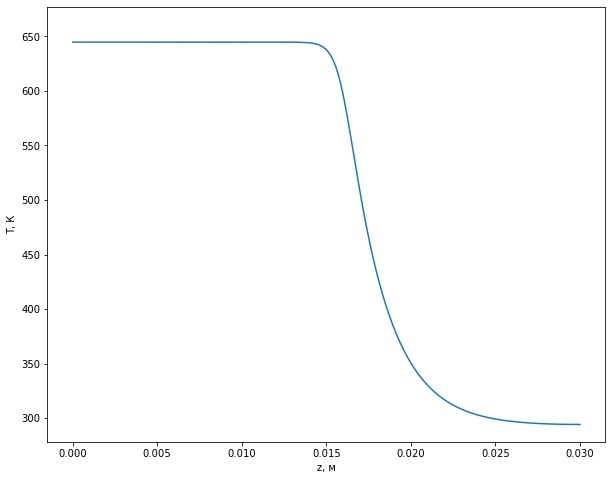

In [302]:
build_gif(Ts, 'T_regular', 'z, м', 'T, К')

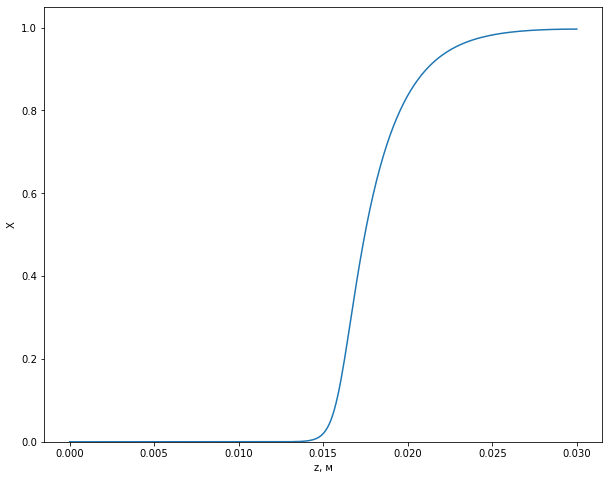

In [303]:
build_gif(Xs, 'X_regular', 'z, м', 'X')

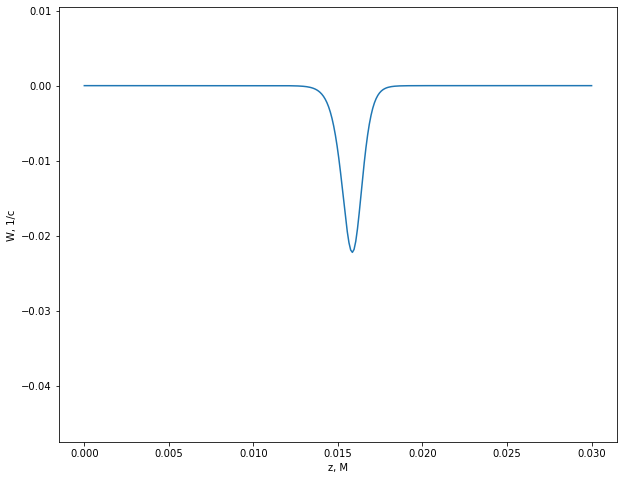

In [304]:
build_gif(Ws, 'W_regular', 'z, М', 'W, 1/с', -0.05, 0.01)

In [305]:
def build_image(Ys, xlabel_name, ylabel_name, min_lim=0, max_lim=0, step=100):
    fig, ax = plt.subplots(figsize=(10,8))
    if min_lim == 0:
        min_lim = np.min(Ys)
        
    if max_lim == 0:
        max_lim = np.max(Ys)        
    ax.set_ylim(0.95*min_lim, max_lim*1.05)
    plt.xlabel(xlabel_name)
    plt.ylabel(ylabel_name)
    x = np.linspace(a, b, num=z_steps)
    line, = ax.plot(x, Ys[0])
    for i in range(0, len(Ys), step):
        ax.plot(x, Ys[i]) 
    plt.show()

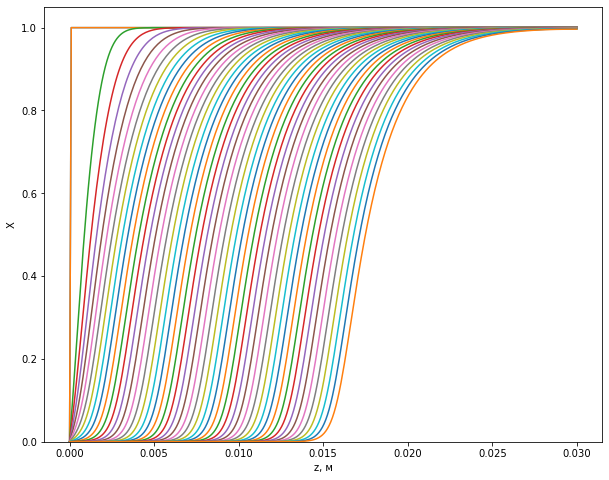

In [306]:
build_image(Xs, 'z, м', 'X', step=1000)

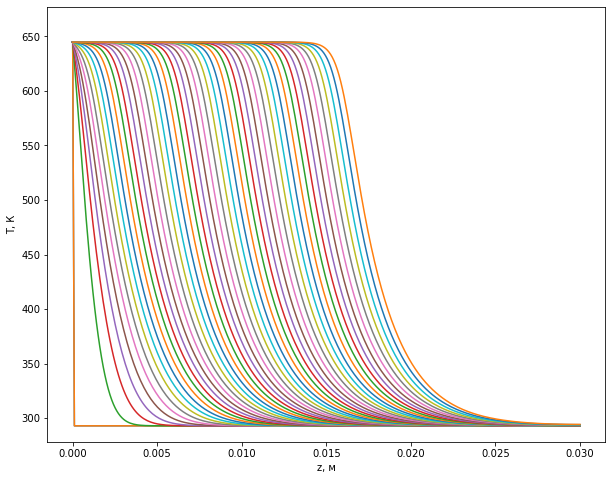

In [307]:
build_image(Ts, 'z, м', 'T, К', step=1000)

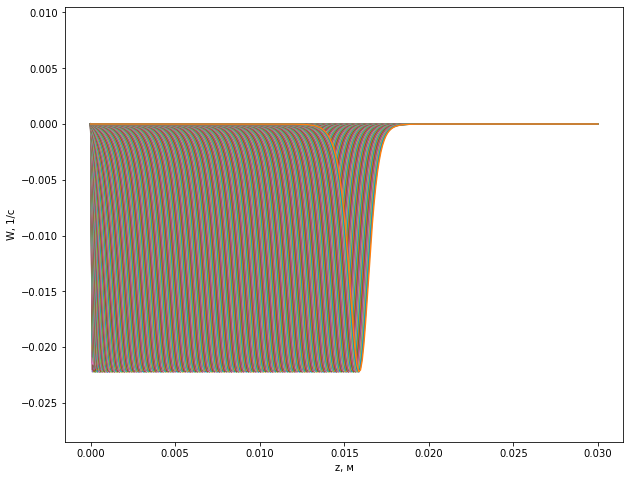

In [308]:
build_image(Ws, 'z, м', 'W, 1/с', -0.03, 0.01)

In [309]:
D = 8e-12
update_constants()

print('Le    = ', Le)
print('beta  = ', beta)
print('gamma = ', gamma)

Le    =  0.00010164307692307692
beta  =  0.06697431972361809
gamma =  0.1227610577254038


In [310]:
Ts, Xs, Ws = explicit_downstream()

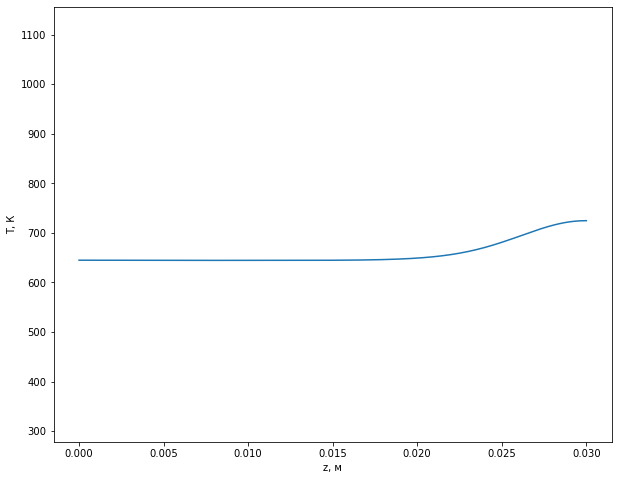

In [311]:
build_gif(Ts, 'T_default', 'z, м', 'T, К')

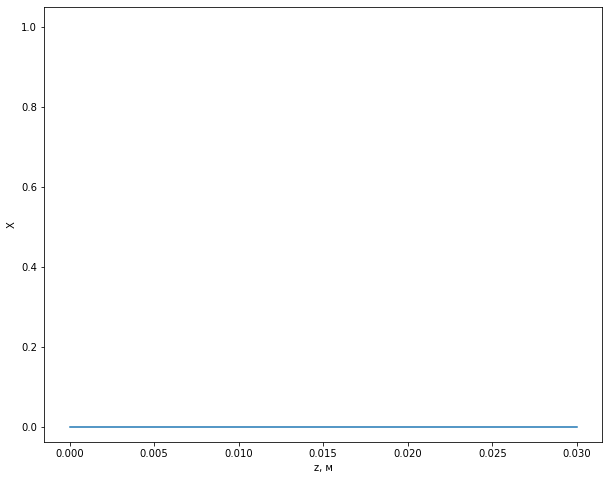

In [312]:
build_gif(Xs, 'X_default', 'z, м', 'X')

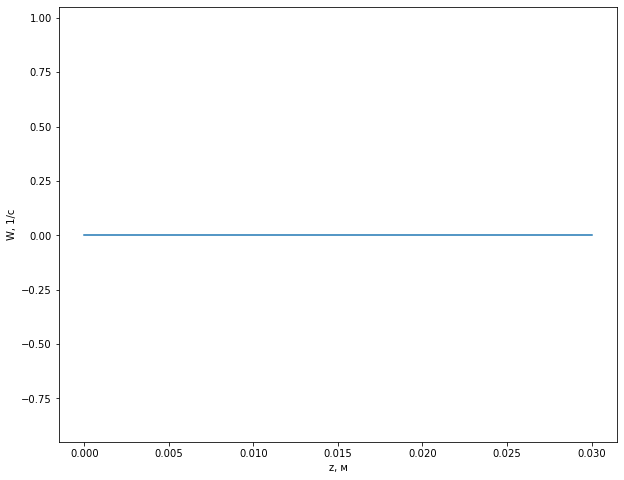

In [313]:
build_gif(Ws, 'W_default', 'z, м', 'W, 1/c', -1, 1)

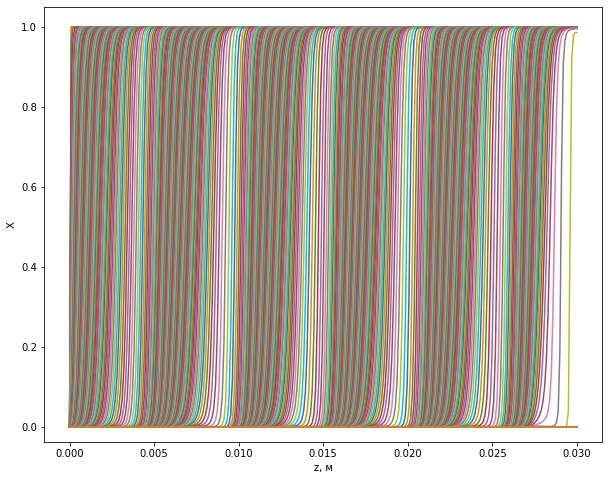

In [314]:
build_image(Xs, 'z, м', 'X')

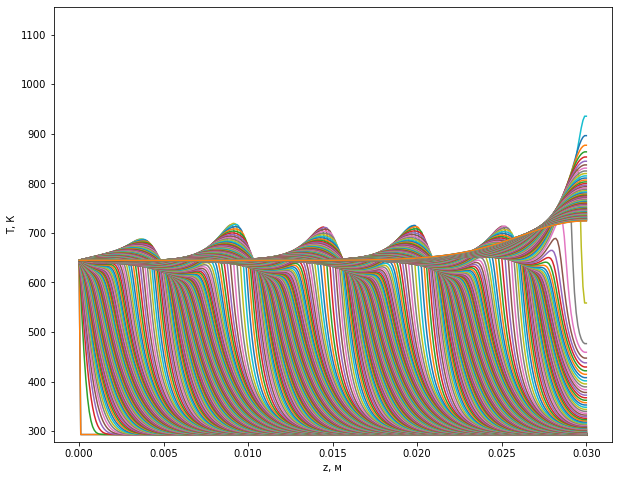

In [315]:
build_image(Ts, 'z, м', 'T, К')

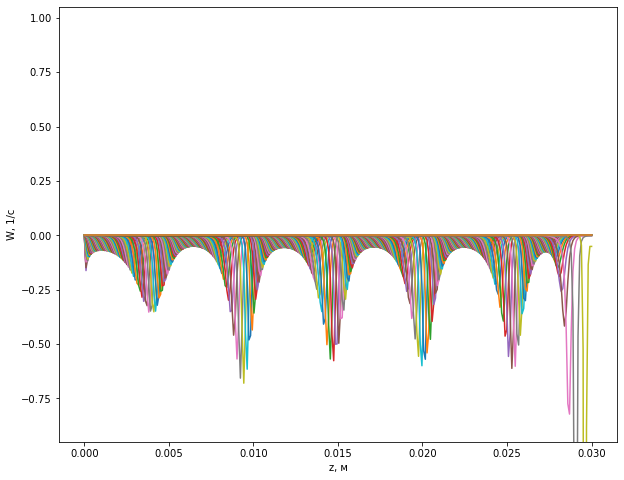

In [316]:
build_image(Ws, 'z, м', 'W, 1/с', -1, 1)

In [337]:
D = 8e-12
K_0 = K
E_0 = E
K = 4e6
print(K_0, K, E_0)
E = E_0 + R * T_m * (math.log(K) - math.log(K_0))
print("D = ", D)
print("K = ", K)
print("E = ", E)

update_constants()

print('Le    = ', Le)
print('beta  = ', beta)
print('gamma = ', gamma)

4000000.0 4000000.0 84909.43587490621
D =  8e-12
K =  4000000.0
E =  84909.43587490621
Le    =  0.0001016430769230769
beta  =  0.06310188641204849
gamma =  0.11566305342672437


In [338]:
Ts, Xs, Ws = explicit_downstream()

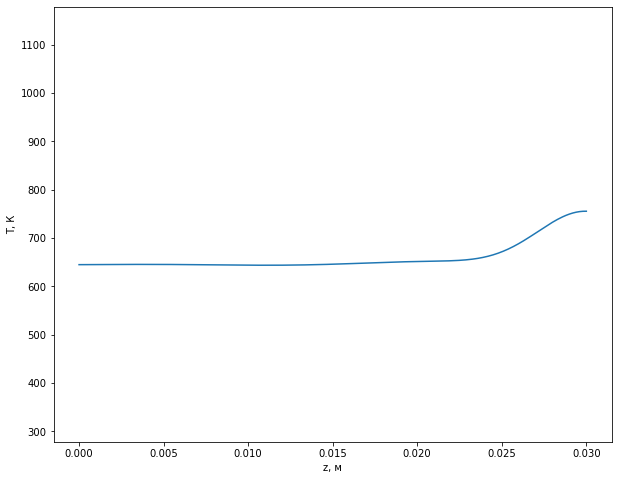

In [339]:
build_gif(Ts, 'T_double_pereodic', 'z, м', 'T, К')

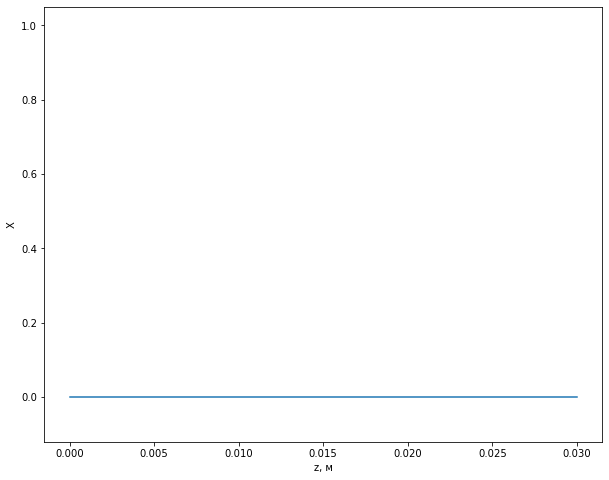

In [340]:
build_gif(Xs, 'X_double_pereodic', 'z, м', 'X')

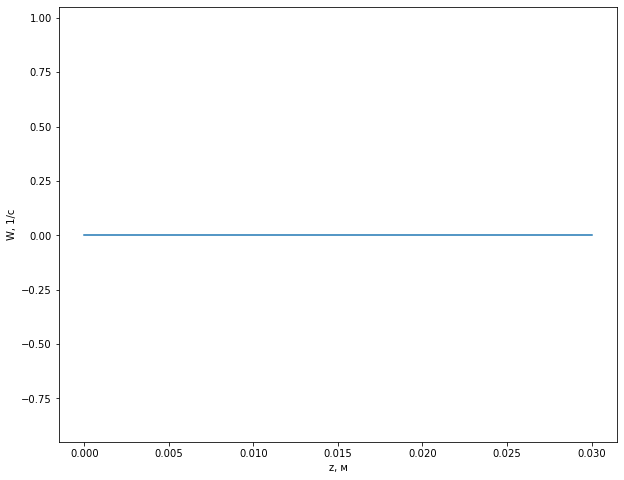

In [341]:
build_gif(Ws, 'W_double_pereodic', 'z, м', 'W, 1/с', -1, 1)

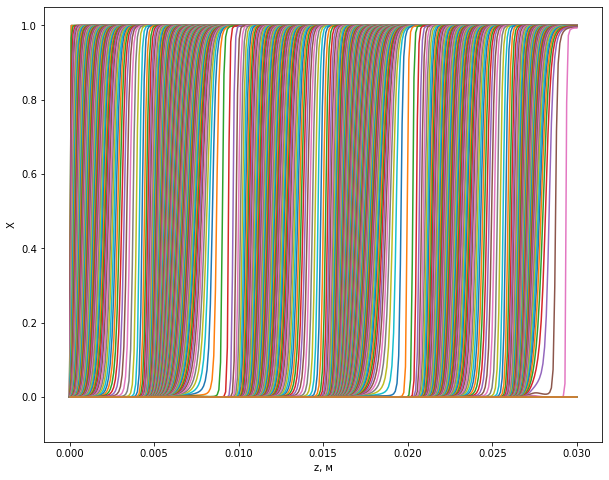

In [342]:
build_image(Xs, 'z, м', 'X')

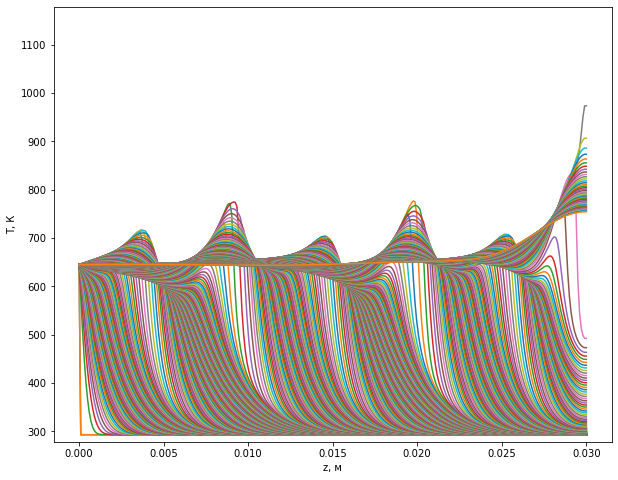

In [343]:
build_image(Ts, 'z, м', 'T, К')

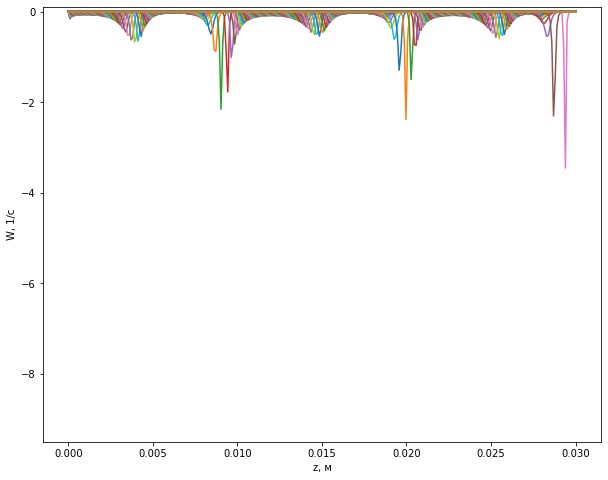

In [344]:
build_image(Ws, 'z, м', 'W, 1/с', -10, 0.1)

In [345]:
D = 8e-14
K_0 = K
E_0 = E
K = 4e7
print(K_0, K, E_0)
E = E_0 + R * T_m * (math.log(K) - math.log(K_0))
print("D = ", D)
print("K = ", K)
print("E = ", E)

update_constants()

print('Le    = ', Le)
print('beta  = ', beta)
print('gamma = ', gamma)

4000000.0 40000000.0 84909.43587490621
D =  8e-14
K =  40000000.0
E =  97246.56149162783
Le    =  1.0164307692307693e-06
beta  =  0.05509650414067056
gamma =  0.10098953081110025


In [347]:
Ts, Xs, Ws = explicit_downstream()

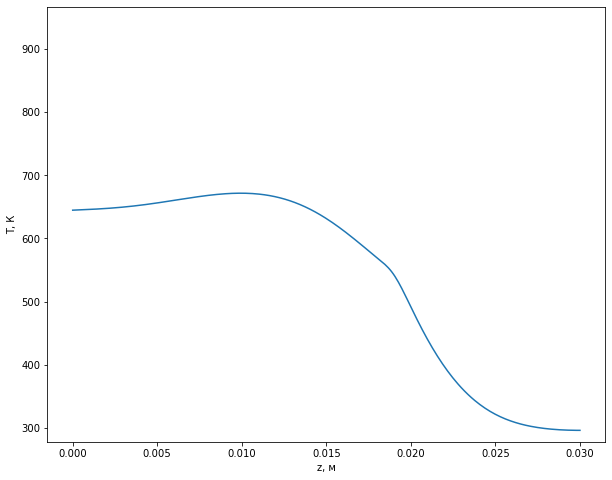

In [348]:
build_gif(Ts, 'T_chaos', 'z, м', 'T, К')

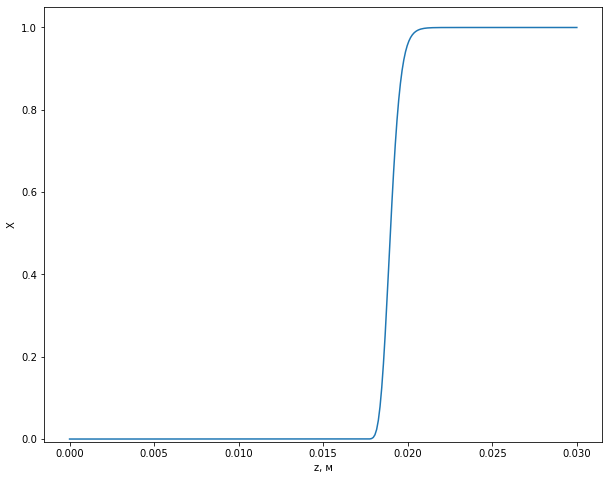

In [349]:
build_gif(Xs, 'X_chaos', 'z, м', 'X')

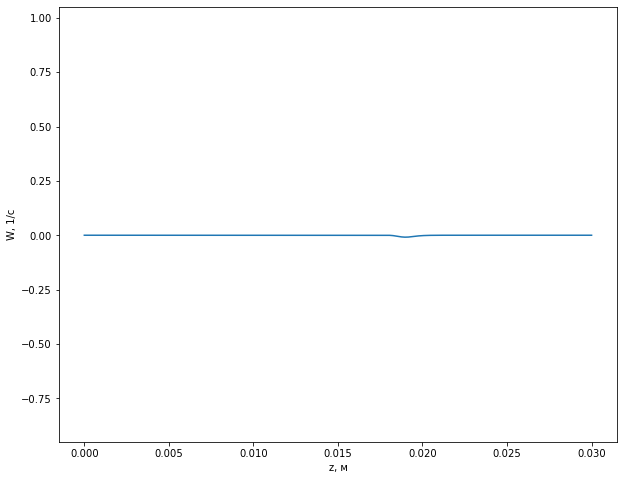

In [350]:
build_gif(Ws, 'W_chaos', 'z, м', 'W, 1/с', -1, 1)

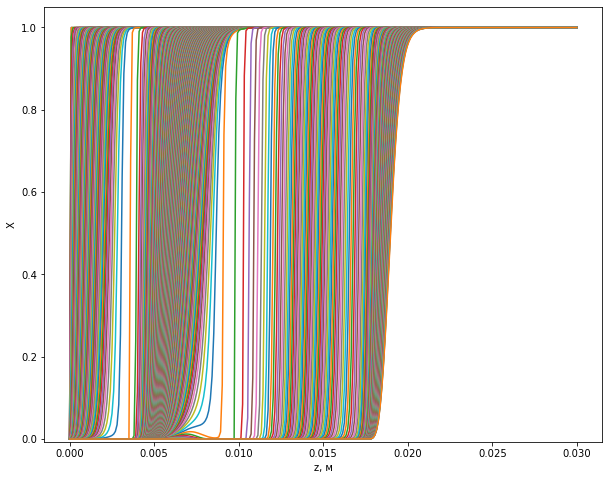

In [351]:
build_image(Xs, 'z, м', 'X')

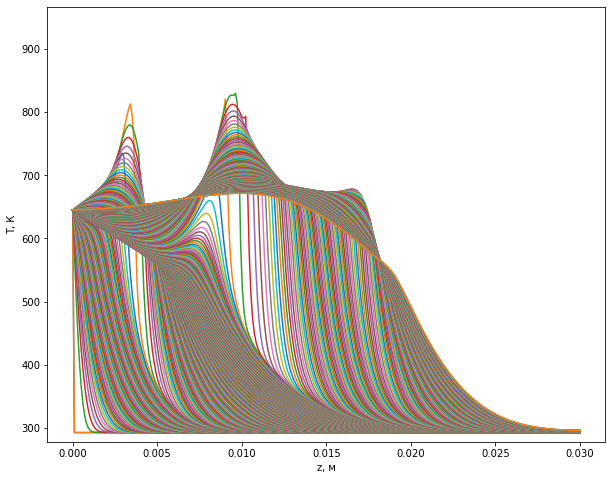

In [352]:
build_image(Ts, 'z, м', 'T, К')

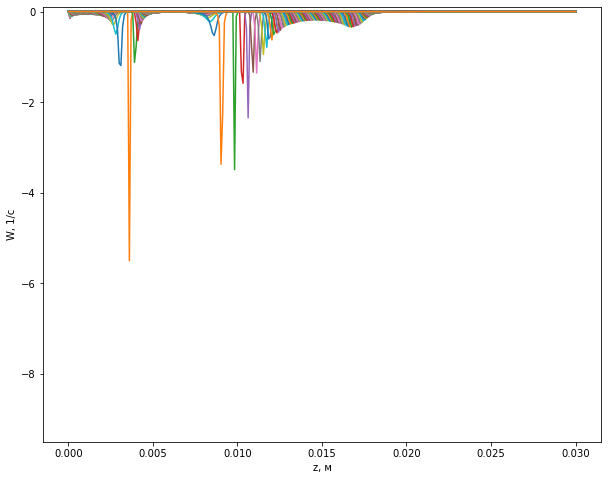

In [353]:
build_image(Ws, 'z, м', 'W, 1/с', -10, 0.1)